In [1]:
%cd '/teamspace/studios/this_studio/sam-hq'
!export PYTHONPATH=$(pwd)
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.transforms import ResizeLongestSide

/teamspace/studios/this_studio/sam-hq


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]
/teamspace/studios/this_studio/sam-hq/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_5m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/teamspace/studios/this_studio/sam-hq/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_11m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/teamspace/studios/this_studio/sam-hq/segment_anything/modeling/tiny_vi

In [2]:
    sam_checkpoint = "pretrained_checkpoint/sam_hq_vit_l.pth"
    model_type = "vit_l"
    device = "cuda"
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)
    predictor = SamPredictor(sam)


<All keys matched successfully>


In [3]:
%cd /teamspace/studios/this_studio/Deeplab/
from inference.infer import *
from post_processing.control_random_field import *

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/teamspace/studios/this_studio/Deeplab


In [4]:
from torch.nn.functional import threshold, normalize
from scipy.special import expit
def normalize_0_1(tensor):
    """
    Normalizes a tensor to the range [0, 1]
    """
    min_val = torch.min(tensor)
    max_val = torch.max(tensor)
    normalized_tensor = (tensor - min_val) / (max_val - min_val)
    return normalized_tensor
    
def get_prob(img_path, box):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image_size = image.shape[:2]
    transform = ResizeLongestSide(sam.image_encoder.img_size)
    input_image_torch = torch.as_tensor(image, device=device)
    transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
    box = transform.apply_boxes(box, original_image_size)
    box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
    box_torch = box_torch[None, :]
    input_image = sam.preprocess(transformed_image)
    input_size = tuple(transformed_image.shape[-2:])
    with torch.no_grad():
        sparse_embeddings, dense_embeddings = sam.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )
        #image_embedding = sam.image_encoder(input_image)
        features, interm_features = sam.image_encoder(input_image)
        low_res_masks, iou_predictions = sam.mask_decoder(
              image_embeddings=features,
              image_pe=sam.prompt_encoder.get_dense_pe(),
              sparse_prompt_embeddings=sparse_embeddings,
              dense_prompt_embeddings=dense_embeddings,
              multimask_output=False,
              hq_token_only = False,
              interm_embeddings = interm_features,
    
            )
        upscaled_masks = sam.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)

    
    return normalize(threshold(upscaled_masks, 0.0, 0))
    
def get_logits(img_path, box = None):
    predictor.set_image(np.array(flip(Image.open(img_path))))
    #input_box =  box
    masks, scores, logits = predictor.predict(
                point_coords=None,
                point_labels=None,
                box= box[None, :],
                multimask_output=False,
                return_logits = True,
            )
    #print(scores[0]) 
    
    return expit(masks[0])

    

In [20]:
def get_box_from_deeplab(checkpoint, img_path, folder_name = 'probs'):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = load_deeplab_model(checkpoint, device).eval()
    img = Image.open(img_path)
    
    img_transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = img_transform(img).unsqueeze(0).to(device, dtype=torch.float32)
    
    with torch.no_grad():
        output = model(img_tensor)
        output = torch.squeeze(output, dim=1)
        prob = torch.sigmoid(output).detach()
        pred = (prob > 0.5).long().cpu().numpy()[0]
    
    prob_np = prob[0].cpu().numpy()
    cleaned_mask = crf_with_prob(np.array(img), (pred * 255).astype(np.uint8), prob_np)
    cleaned_mask_img = Image.fromarray((cleaned_mask * 255).astype(np.uint8))
    #pred_rgb = np.array(pred*255).astype(np.uint8)
    #pred_image = Image.fromarray(pred_rgb).convert('RGB')
    #box = masks_to_boxes(pil_to_grayscale_tensor(cleaned_mask_img)).numpy()
    
    return pred

            
            

In [12]:
img_path = '/teamspace/studios/this_studio/Deeplab/crf_sam_annotations_large/samples/eastafrica_gmelarbo_2021.05.26.07.57.41_3.0230813333333337_32.46219800000001_229166e9-994c-4242-ac2e-4c635e180939_img_20210519_124400_7282320644335042953.jpg'

In [13]:
from torchvision.ops import masks_to_boxes
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inhouse_default = '/teamspace/studios/this_studio/Deeplab/saved_models/best_deeplabv3plus_mobilenet_custom_os16_0.7854892764326529.pth'

In [21]:
crf_img = get_box_from_deeplab(inhouse_default, img_path)

Device: cuda
Resume model from /teamspace/studios/this_studio/Deeplab/saved_models/best_deeplabv3plus_mobilenet_custom_os16_0.7854892764326529.pth


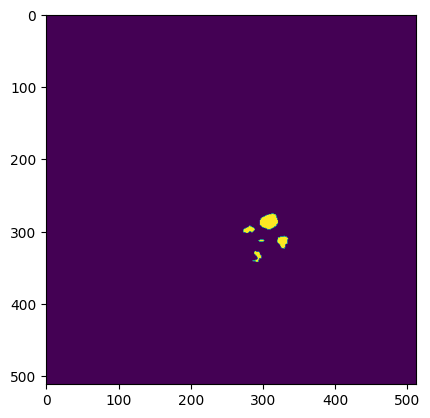

In [22]:
plt.imshow(Image.fromarray((crf_img * 255).astype(np.uint8)))
plt.show()

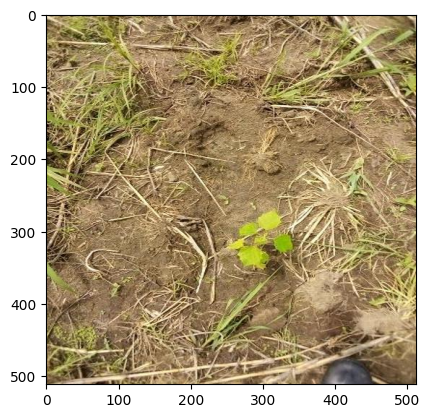

In [23]:
plt.imshow(Image.open(img_path))
plt.show()